In [13]:
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
path = '../data/processed_price_paid/price_paid_2024.parquet'
ONSPD_path = "../data/ocod_history_processed/OCOD_FULL_2017_03.parquet"
figures_folder = Path('../figures')


In [3]:
test = pd.read_parquet(ONSPD_path)


In [4]:
def create_time_series_by_groups(grouping_vars=None):
    """
    Create time series with optional grouping variables
    
    Args:
        grouping_vars (list or None): List of column names to group by (e.g., ['region'])
    """
    ocod_path = Path('../data/ocod_history_processed')
    price_paid_path = Path('../data/price_paid_msoa_averages')

    # List to store results
    results = []

    # Get all parquet files from ocod directory
    ocod_files = list(ocod_path.glob('*.parquet'))

    for ocod_file in tqdm(ocod_files):
        # Extract year and month from filename
        filename_parts = ocod_file.stem.split('_')
        year = int(filename_parts[-2])
        month = int(filename_parts[-1])
        
        # Create corresponding price_paid filename
        price_paid_file = price_paid_path / f'price_paid_{year}_{month:02d}.parquet'
        
        # Check if corresponding price_paid file exists
        if not price_paid_file.exists():
            print(f"Warning: {price_paid_file} not found, skipping...")
            continue
        
        try:
            # Read the data
            ocod_df = pd.read_parquet(ocod_file)
            price_paid_df = pd.read_parquet(price_paid_file)
            
            # Filter for residential properties
            ocod_residential = ocod_df.loc[ocod_df['class2']=='residential'].copy()
            
            # Skip if no residential properties
            if ocod_residential.empty:
                print(f"Warning: No residential properties for {year}-{month:02d}, skipping...")
                continue
            
            # Determine grouping columns
            if grouping_vars is None:
                group_cols = ['msoa11cd']
            else:
                group_cols = ['msoa11cd'] + grouping_vars
            
            # Group and count
            ocod_grouped = ocod_residential.groupby(group_cols).size().reset_index().rename(columns={0:'counts'})
            
            # Merge with price data
            df = price_paid_df.merge(ocod_grouped, on='msoa11cd')
            
            # Skip if no data after merge
            if df.empty:
                print(f"Warning: No data after merge for {year}-{month:02d}, skipping...")
                continue
            
            # Create date as first day of the month
            date = datetime(year, month, 1)
            
            # Group by additional variables if specified
            if grouping_vars is None:
                # No additional grouping - aggregate all data
                # Weighted averages (by offshore property counts)
                ocod_weighted_mean = np.average(df['price_mean'], weights=df['counts'])
                ocod_weighted_median = np.average(df['price_median'], weights=df['counts'])
                
                # Unweighted averages (treating all MSOAs equally)
                ocod_unweighted_mean = df['price_mean'].mean()
                ocod_unweighted_median = df['price_median'].mean()
                
                # Calculate ratios
                weighted_unweighted_mean_ratio = ocod_weighted_mean / ocod_unweighted_mean
                weighted_unweighted_median_ratio = ocod_weighted_median / ocod_unweighted_median
                
                results.append({
                    'date': date,
                    'year': year,
                    'month': month,
                    'ocod_weighted_mean': int(ocod_weighted_mean),
                    'ocod_weighted_median': int(ocod_weighted_median),
                    'ocod_unweighted_mean': int(ocod_unweighted_mean),
                    'ocod_unweighted_median': int(ocod_unweighted_median),
                    'weighted_unweighted_mean_ratio': weighted_unweighted_mean_ratio,
                    'weighted_unweighted_median_ratio': weighted_unweighted_median_ratio
                })
            else:
                # Group by additional variables
                for group_values, group_df in df.groupby(grouping_vars):
                    if group_df.empty:
                        continue
                    
                    # Weighted averages (by offshore property counts)
                    ocod_weighted_mean = np.average(group_df['price_mean'], weights=group_df['counts'])
                    ocod_weighted_median = np.average(group_df['price_median'], weights=group_df['counts'])
                    
                    # Unweighted averages (treating all MSOAs equally)
                    ocod_unweighted_mean = group_df['price_mean'].mean()
                    ocod_unweighted_median = group_df['price_median'].mean()
                    
                    # Calculate ratios
                    weighted_unweighted_mean_ratio = ocod_weighted_mean / ocod_unweighted_mean
                    weighted_unweighted_median_ratio = ocod_weighted_median / ocod_unweighted_median
                    
                    # Create result dictionary
                    result = {
                        'date': date,
                        'year': year,
                        'month': month,
                        'ocod_weighted_mean': int(ocod_weighted_mean),
                        'ocod_weighted_median': int(ocod_weighted_median),
                        'ocod_unweighted_mean': int(ocod_unweighted_mean),
                        'ocod_unweighted_median': int(ocod_unweighted_median),
                        'weighted_unweighted_mean_ratio': weighted_unweighted_mean_ratio,
                        'weighted_unweighted_median_ratio': weighted_unweighted_median_ratio
                    }
                    
                    # Add grouping variables to result
                    if isinstance(group_values, tuple):
                        for i, var in enumerate(grouping_vars):
                            result[var] = group_values[i]
                    else:
                        result[grouping_vars[0]] = group_values
                    
                    results.append(result)
                
        except Exception as e:
            print(f"Error processing {ocod_file.name}: {str(e)}")
            continue

    # Create DataFrame from results
    time_series_df = pd.DataFrame(results)
    
    if not time_series_df.empty:
        # Sort by date and grouping variables for proper time series
        sort_cols = ['date']
        if grouping_vars:
            sort_cols.extend(grouping_vars)
        time_series_df = time_series_df.sort_values(sort_cols).reset_index(drop=True)
    
    return time_series_df

In [5]:

df_msoa_region = create_time_series_by_groups( ['region'])


100%|██████████| 99/99 [00:24<00:00,  4.10it/s]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/relative_value_excluding_london.png


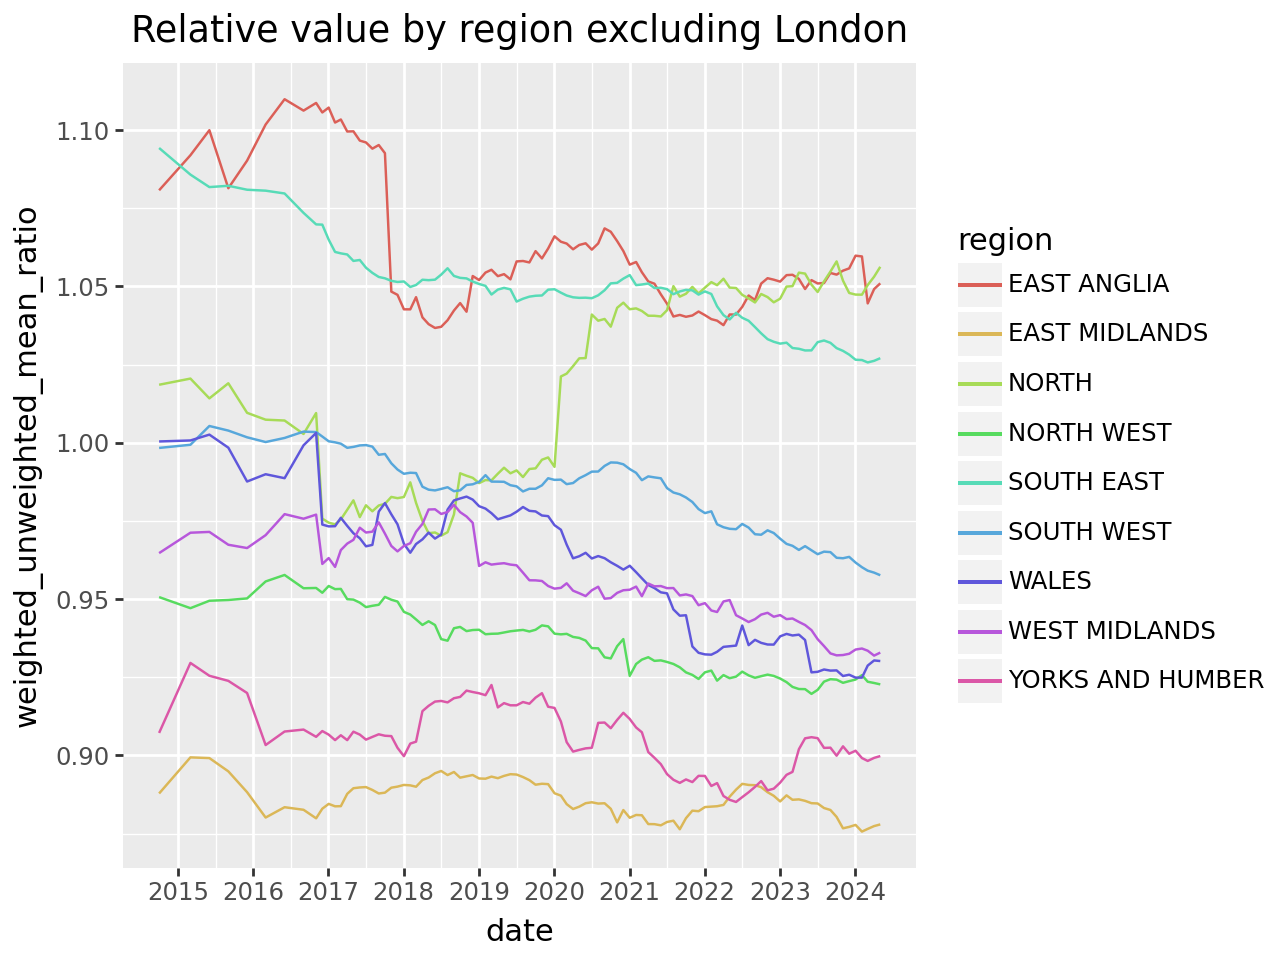

In [56]:
p = ggplot(df_msoa_region.loc[df_msoa_region['region']!='GREATER LONDON'], aes(x = 'date', y = 'weighted_unweighted_mean_ratio', color = 'region')) + geom_line() + labs(
    title = "Relative value by region excluding London") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 )

p.save(filename = 'figures/relative_value_excluding_london.png')

p

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/relative_value_region.png


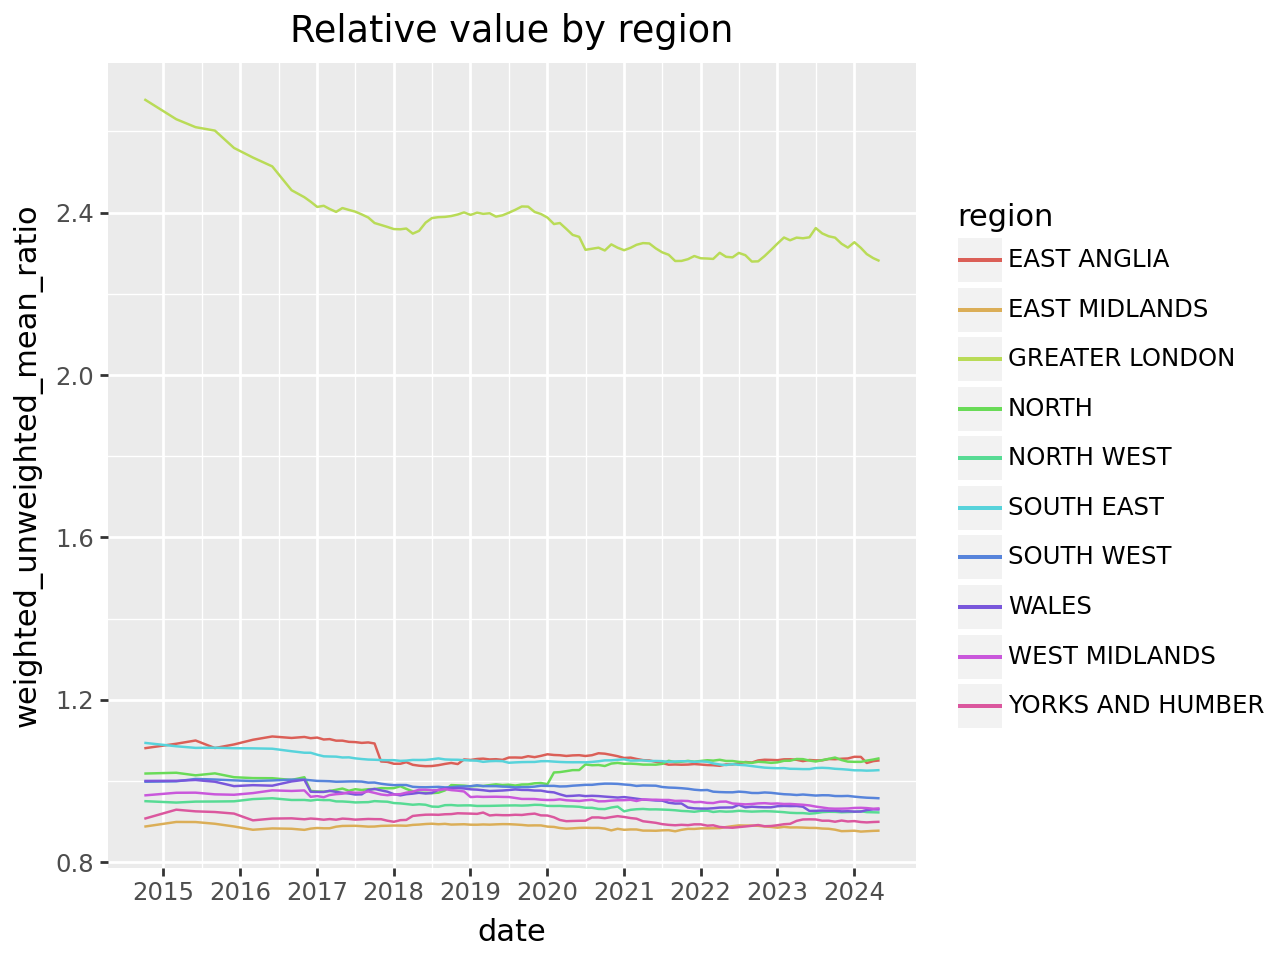

In [79]:
p = ggplot(df_msoa_region, aes(x = 'date', y = 'weighted_unweighted_mean_ratio', color = 'region')) + geom_line() + labs(
    title = "Relative value by region") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 )


p.save(filename = 'figures/relative_value_region.png')

p

In [9]:
df_msoa_nested = create_time_series_by_groups( ['nested_title'])

100%|██████████| 99/99 [00:23<00:00,  4.18it/s]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/relative_value_nested.png


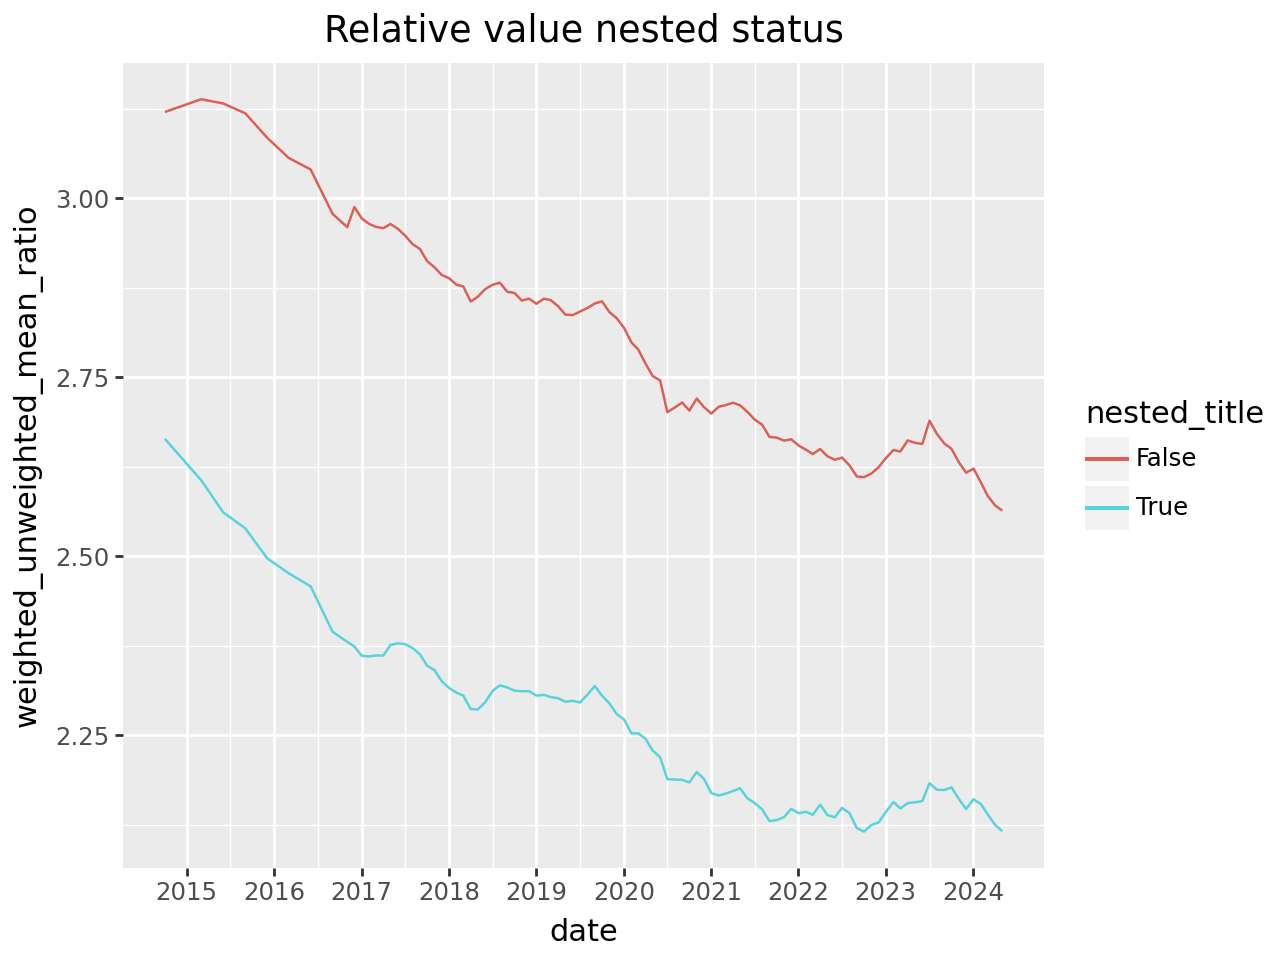

In [60]:
p = ggplot(df_msoa_nested, aes(x = 'date', y = 'weighted_unweighted_mean_ratio', color = 'nested_title')) + geom_line() + labs(
    title = "Relative value nested status") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 )

p.save(filename = 'figures/relative_value_nested.png')

p

In [16]:
df_msoa_incorporated = create_time_series_by_groups( ['country_incorporated'])

100%|██████████| 99/99 [00:32<00:00,  3.08it/s]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/relative_value_incorporation.png


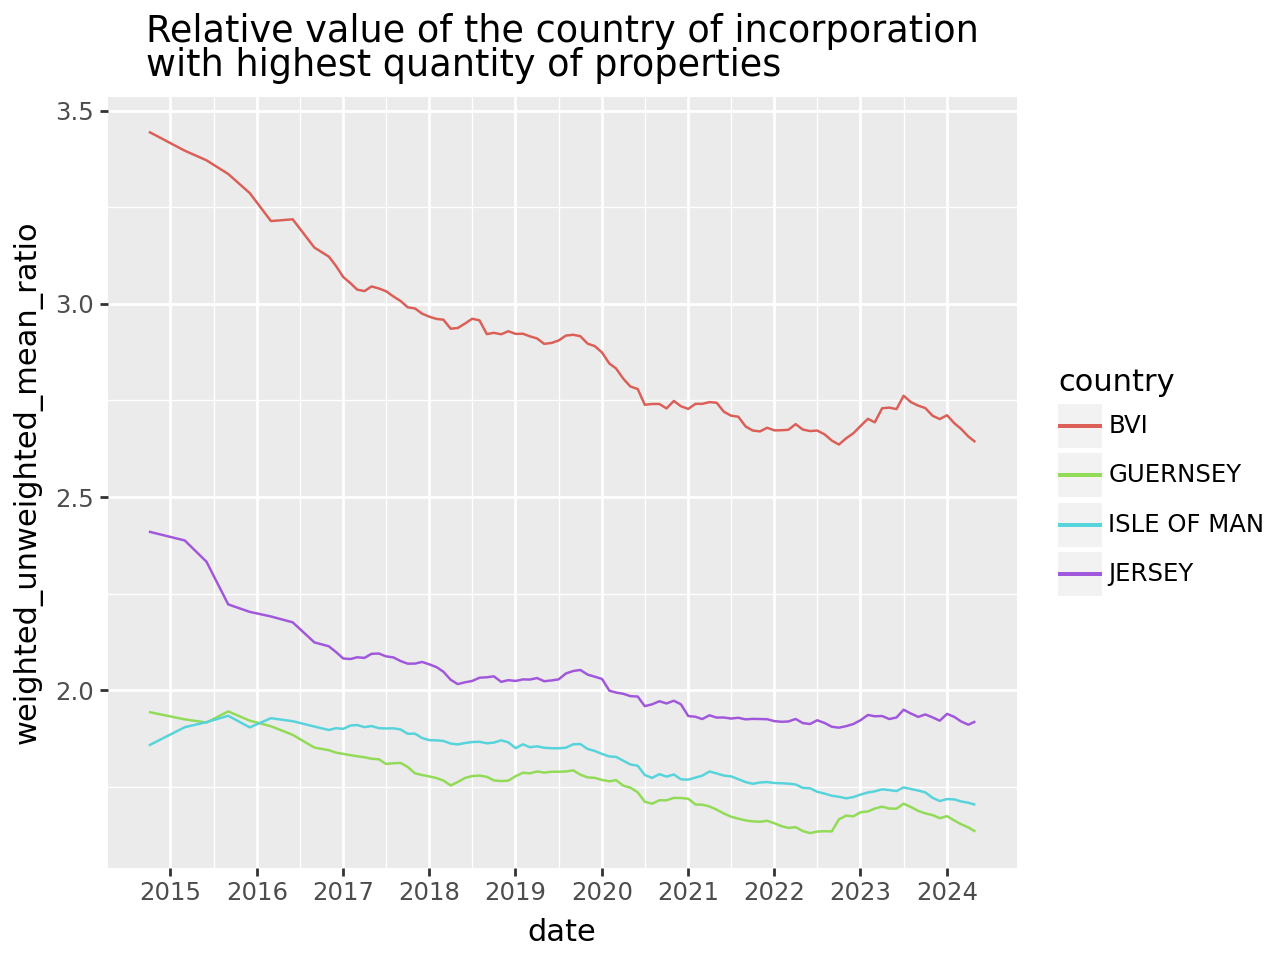

In [62]:
df_msoa_incorporated['country_incorporated'] = df_msoa_incorporated['country_incorporated'].str.replace("BRITISH VIRGIN ISLANDS", "BVI")

p =  ggplot(df_msoa_incorporated.loc[df_msoa_incorporated['country_incorporated'].isin(['JERSEY', 'GUERNSEY', 
'ISLE OF MAN', 'BRITISH VIRGIN ISLANDS', 'BVI'])], 
aes(x = 'date', y = 'weighted_unweighted_mean_ratio', color = 'country_incorporated')) + geom_line() + labs(
    title = "Relative value of the country of incorporation\nwith highest quantity of properties") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 ) + \
  guides(color = guide_legend(title = "country")) 

p.save(filename = 'figures/relative_value_incorporation.png')

p

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/relative_value_incorporation_increases.png


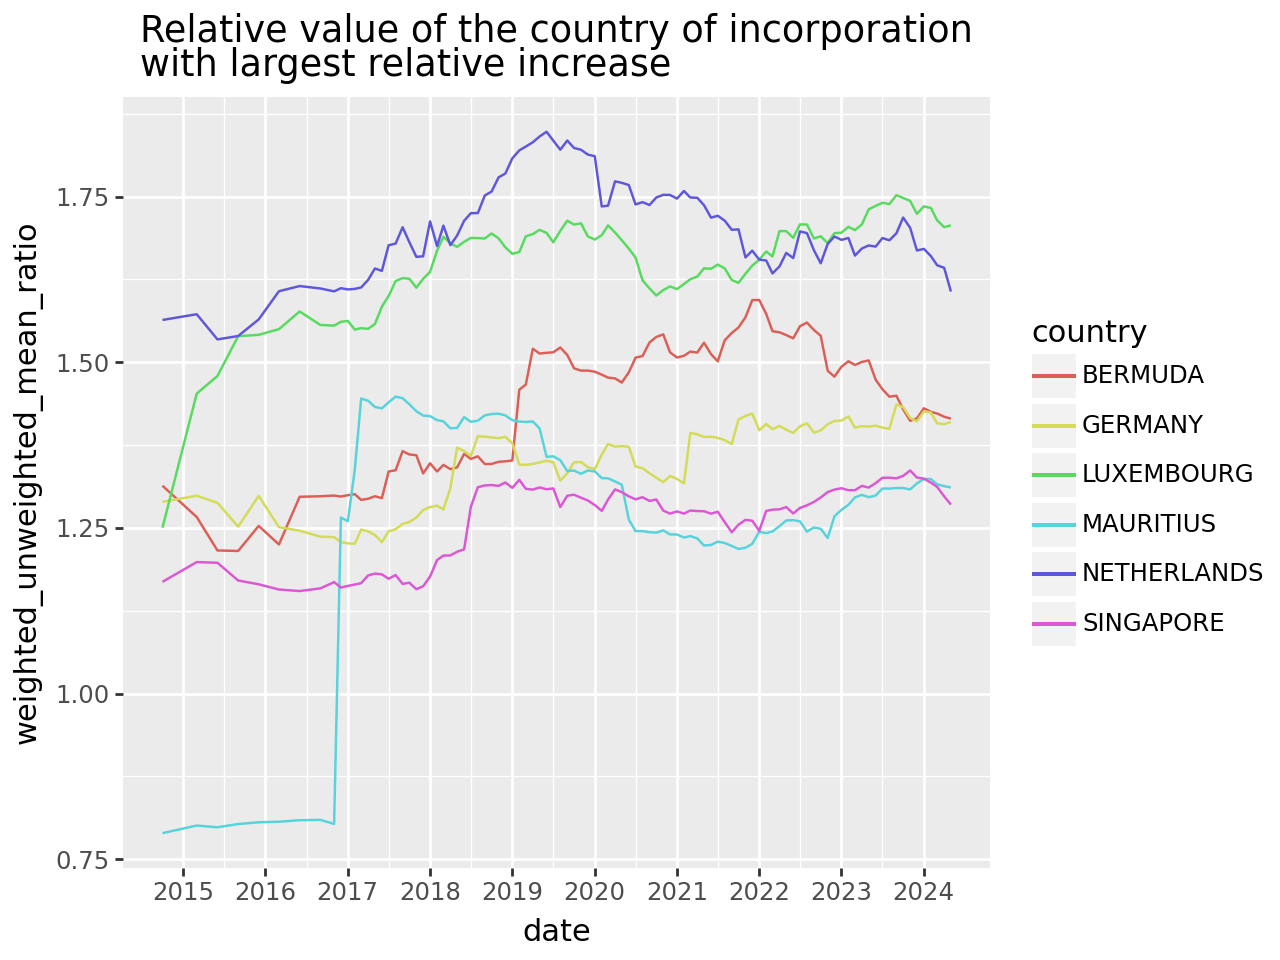

In [64]:
df_msoa_incorporated['country_incorporated'] = df_msoa_incorporated['country_incorporated'].str.replace("BRITISH VIRGIN ISLANDS", "BVI")

p = ggplot(df_msoa_incorporated.loc[df_msoa_incorporated['country_incorporated'].isin([ 'LUXEMBOURG', 'MAURITIUS', 
'SINGAPORE', 'GERMANY', 'BERMUDA', 'NETHERLANDS'])], 
aes(x = 'date', y = 'weighted_unweighted_mean_ratio', color = 'country_incorporated')) + geom_line() + labs(
    title = "Relative value of the country of incorporation\nwith largest relative increase") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 ) + \
  guides(color = guide_legend(title = "country")) 

p.save(filename = 'figures/relative_value_incorporation_increases.png')

p

In [35]:
countries = [
    "JERSEY",
    "BVI",
    "GUERNSEY",
    "ISLE OF MAN",
    "GIBRALTAR",
    "LUXEMBOURG",
    "SINGAPORE",
    "IRELAND",
    "HONG KONG",
    "PANAMA",
    "CAYMAN ISLANDS",
    "SEYCHELLES",
    "NETHERLANDS",
    "CYPRUS",
    "BAHAMAS",
    "MAURITIUS",
    "GERMANY",
    "AUSTRALIA",
    "BERMUDA",
    "DELAWARE, U.S.A."
]

In [51]:
df = df_msoa_incorporated.loc[df_msoa_incorporated['country_incorporated'].isin(countries)]

# Get values at min and max dates
grouped = df.groupby('country_incorporated').apply(
    lambda x: pd.Series({
        'min_date_value': x.loc[x['date'].idxmin(), 'weighted_unweighted_mean_ratio'],
        'max_date_value': x.loc[x['date'].idxmax(), 'weighted_unweighted_mean_ratio']
    })
)

# Calculate ratio of change
grouped['ratio_change'] = grouped['max_date_value'] / grouped['min_date_value']
result = grouped['ratio_change']

result.sort_values().reset_index()

/tmp/ipykernel_519347/3819271352.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,country_incorporated,ratio_change
0,AUSTRALIA,0.639478
1,BVI,0.766989
2,JERSEY,0.796234
3,CAYMAN ISLANDS,0.830600
4,GUERNSEY,0.840845
5,BAHAMAS,0.873460
6,SEYCHELLES,0.878846
7,HONG KONG,0.910346
8,PANAMA,0.916263
9,ISLE OF MAN,0.917338


In [67]:
df

,date,year,month,ocod_weighted_mean,ocod_weighted_median,ocod_unweighted_mean,ocod_unweighted_median,weighted_unweighted_mean_ratio,weighted_unweighted_median_ratio,country_incorporated
38,2015-10-01,2015,10,957090,680779,606322,455655,1.578516,1.494067,AUSTRALIA
40,2015-10-01,2015,10,1092434,778875,551529,430887,1.980736,1.807608,BAHAMAS
49,2015-10-01,2015,10,552631,418121,420709,327876,1.313571,1.275242,BERMUDA
52,2015-10-01,2015,10,1145494,811925,332477,282893,3.445335,2.870070,BVI
57,2015-10-01,2015,10,888002,636009,442248,344353,2.007928,1.846966,CAYMAN ISLANDS
...,...,...,...,...,...,...,...,...,...,...
19527,2025-05-01,2025,5,1006787,727208,767917,585257,1.311062,1.242545,MAURITIUS
19534,2025-05-01,2025,5,1091062,773259,679107,529623,1.606613,1.460019,NETHERLANDS
19555,2025-05-01,2025,5,2022104,1259178,833836,625064,2.425062,2.014477,PANAMA
19571,2025-05-01,2025,5,725950,560715,576920,472886,1.258320,1.185728,SEYCHELLES


In [10]:

df_msoa_region_nested = create_time_series_by_groups( ['region', 'nested_title'])

100%|██████████| 99/99 [00:25<00:00,  3.91it/s]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/relative_value_nested_region.png


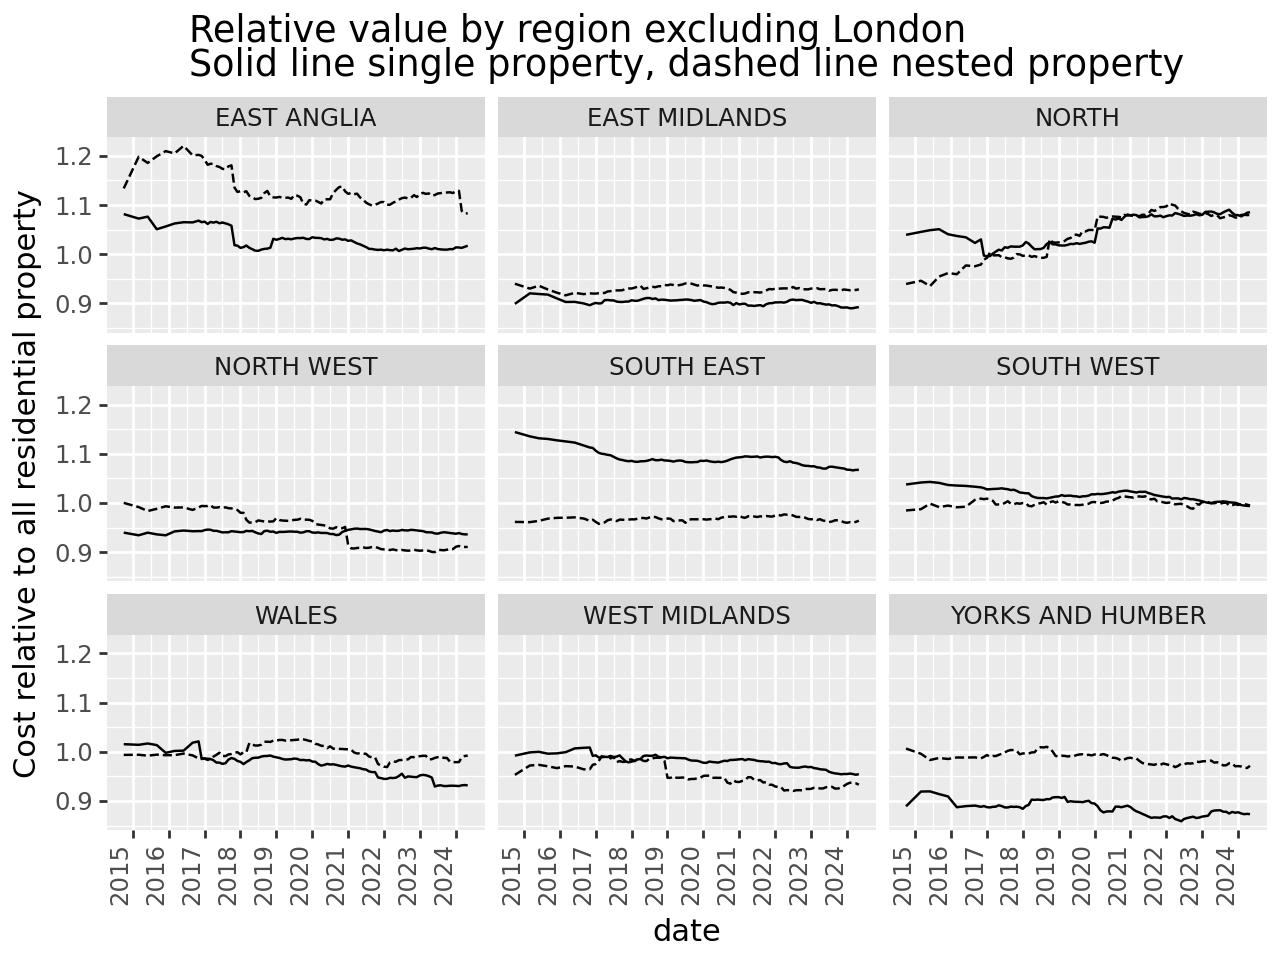

In [19]:
p = ggplot(df_msoa_region_nested.loc[df_msoa_region_nested['region']!='GREATER LONDON'], 
aes(x = 'date', y = 'weighted_unweighted_mean_ratio', linetype = 'nested_title')) + geom_line() + labs(
    title = "Relative value by region excluding London\nSolid line single property, dashed line nested property",
    linetype = 'nested',
    y = 'Cost relative to all residential property') +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region_nested['date'].min(), end=df_msoa_region_nested['date'].max(), freq='YE'),
     date_labels='%Y'
 ) + facet_wrap("region") +\
    theme(
        axis_text_x=element_text(angle=90,hjust = 1),
        legend_position = 'none'
    )


p.save(filename = figures_folder / 'relative_value_nested_region.png')

p

In [7]:
df_msoa_region = create_time_series_by_groups( ['lad11cd'])


100%|██████████| 99/99 [00:31<00:00,  3.10it/s]


In [8]:
df_msoa_region

,date,year,month,ocod_weighted_mean,ocod_weighted_median,ocod_unweighted_mean,ocod_unweighted_median,weighted_unweighted_mean_ratio,weighted_unweighted_median_ratio,lad11cd
0,2015-10-01,2015,10,85808,75346,102161,94184,0.839931,0.799990,E06000001
1,2015-10-01,2015,10,86316,76982,110463,99959,0.781407,0.770140,E06000002
2,2015-10-01,2015,10,107756,96375,117244,104807,0.919074,0.919547,E06000003
3,2015-10-01,2015,10,150381,138366,129757,120217,1.158943,1.150973,E06000004
4,2015-10-01,2015,10,118703,110795,124006,114807,0.957235,0.965053,E06000005
...,...,...,...,...,...,...,...,...,...,...
31477,2025-05-01,2025,5,229310,205937,196377,176875,1.167701,1.164311,W06000020
31478,2025-05-01,2025,5,368560,336144,374078,340298,0.985250,0.987795,W06000021
31479,2025-05-01,2025,5,236459,218117,226677,209781,1.043154,1.039736,W06000022
31480,2025-05-01,2025,5,260960,238645,271143,245625,0.962445,0.971586,W06000023
